# KeyWordSpotting - LIVE DEMO

In [1]:
#Imports
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import Models #Our models
import LoadAndPreprocessDataset
#.......................

categories=['yes','no','up','down','left','right','on','off','stop','go']
#categories=['yes','no','up','down','left','right','on','off','stop','go','zero','one','two','three','four','five','six','seven','eight','nine','unknown']


## 1) Audio Input
### Recording from microphone

In [ ]:
sr = 16000
seconds = 10

myrec = sd.rec(int(sr*seconds), samplerate=sr, channels=1)
sd.wait()

np.save('LiveDemo/myrec.npy', myrec)

### Reading it from a numpy array

In [2]:
sr=16000
#myrec = np.load("LiveDemo/ONaudioclip.npy")
myrec = np.load("LiveDemo/myrec.npy")

### Reading it from a wav file

In [ ]:
myrec, sr = librosa.load("LiveDemo/audioclip.wav", sr=None)

### Audio Clip Informations

Sample rate =	16000 samples/s
Duration t =	10.0 s
Average intensity =	 0.0032758904


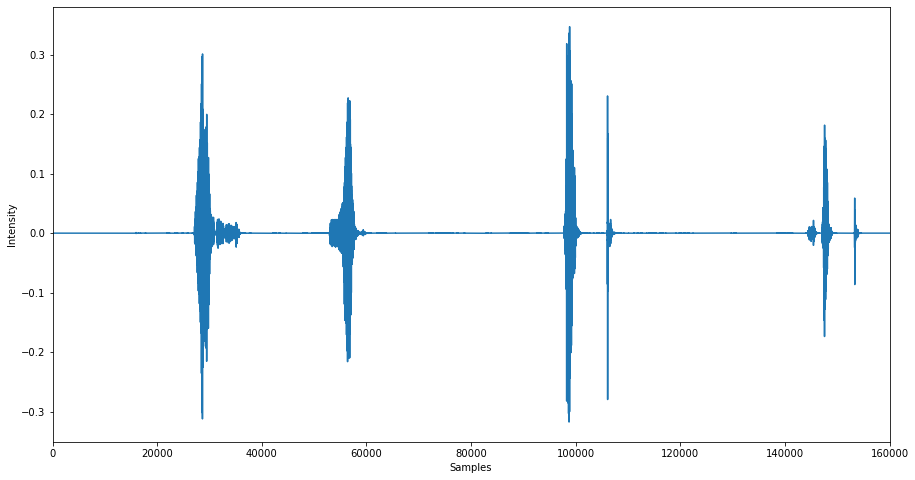

In [3]:
print("Sample rate =\t" + str(sr) + " samples/s")
print("Duration t =\t" + str(len(myrec) / sr) + " s")
print("Average intensity =",np.mean(np.abs(myrec)))

# Play it
play = True
if play:
    sd.play(myrec, sr)
    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(0, len(myrec))
plt.show()

## 2) Load Model

In [4]:
#Load Model
from tensorflow.keras.models import load_model
model_name="2020-07-25_13-50_DSConvModel"
model = load_model('models/'+model_name+'.h5')

## 3) Sliding Window
A 1 second window will slide left to right with a step of 1600 samples (100ms) in order to have 10 windows per second 



Number of windows: 46
Step: 3200
Window 0 Silence
Window 1 Silence
Window 2 Silence
Window 3 Silence
Window 4 yes
Window 5 yes
Window 6 yes
Window 7 yes
Window 8 yes
Window 9 stop
Window 10 Silence
Window 11 Silence
Window 12 Silence
Window 13 no
Window 14 no
Window 15 no
Window 16 no
Window 17 no
Window 18 Silence
Window 19 Silence
Window 20 Silence
Window 21 Silence
Window 22 Silence
Window 23 Silence
Window 24 Silence
Window 25 Silence
Window 26 up
Window 27 up
Window 28 up
Window 29 up
Window 30 up
Window 31 up
Window 32 up
Window 33 up
Window 34 Silence
Window 35 Silence
Window 36 Silence
Window 37 Silence
Window 38 Silence
Window 39 Silence
Window 40 Silence
Window 41 Silence
Window 42 stop
Window 43 stop
Window 44 stop
Window 45 stop


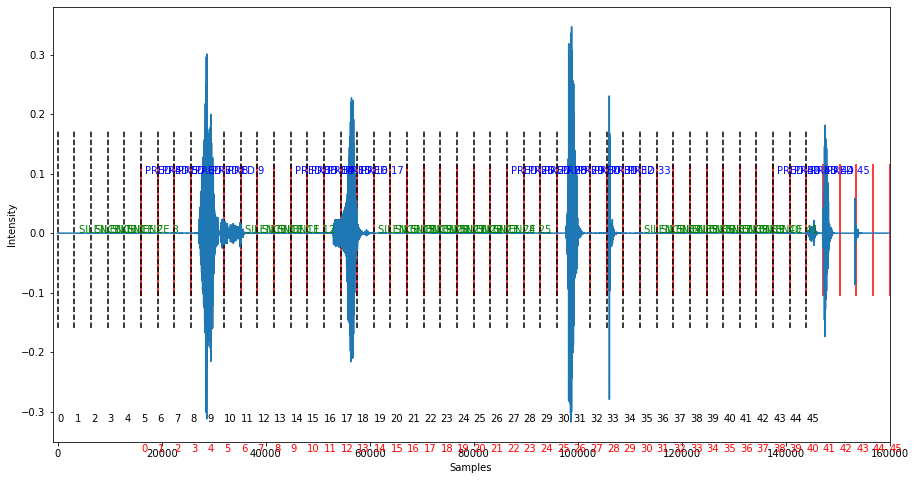

Average prediction speed per window (ms): 41.49


'\nvoice=[] #indeces\nfor i in range(len(predictions)):\n    if predictions[i]!=-1:\n        voice.append(i)\n        plt.title(str(i)+" "+str(int(i*step))+"-"+str(int(i*step)+sr))\n        plt.figure(figsize=(5,2))\n        plt.plot(windows[i])\n        plt.xlabel("Samples")\n        plt.ylabel("Intensity")\n        plt.xlim(0, len(windows[i]))\n\nplt.show()'

In [15]:
###################### PARAMETERS ##########################################

ws=5 #windows per second

#############################################################################

if len(myrec.shape)<2: myrec=myrec[...,np.newaxis] # for the 1 sec audios

step=int(sr/ws)
nwin=int((len(myrec)-sr)/step)+1 #number of windows
windows=np.empty((nwin,sr,1))
predictions=np.empty((nwin,1))

print("Number of windows:",nwin)
print("Step:",step)
#print(windows.shape)
#print(predictions.shape)

#divide in windows
for i in range(nwin):
    start=int(i*step)
    end=int(start+sr)
    windows[i]=myrec[start:end]

    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(-1000, len(myrec))


#prediction speed measure
import time
sStarts=[]
sEnds=[]

for i in range(nwin):
    start=int(i*step)
    plt.vlines(start, np.min(myrec)/2, np.max(myrec)/2, colors='k',linestyles='dashed')
    plt.vlines(start+sr, np.min(myrec)/3, np.max(myrec)/3, colors='r')
    plt.text(start, np.min(myrec), i)
    plt.text(start+sr, np.min(myrec)-0.05, i, color='red')
    
    
    
    #SILENCE FILTER
    if np.mean(np.abs(windows[i]))<(10**-3):
        predictions[i]=-1 #Silence
        plt.text(start+sr/4, 0, "SILENCE "+str(i), color='green')
        #print("Window",i,"Silence",np.mean(np.abs(windows[i])))
        print("Window",i,"Silence")
    else:
        sStarts.append(time.time())
        
        a=windows[i]
        
        #preprocessing:         
        a=np.squeeze(a) #remove dimensions of length 1 (the last dimension)
        a=a[np.newaxis,...] #add dimension 1 at the beginning to indicate 1 example
        #a=LoadAndPreprocessDataset.MFCC(a,n_mfcc=40)
        a=LoadAndPreprocessDataset.melspect(a)
        a=a[...,np.newaxis] #add dimension 1 at the end for CNN
        
        #no preprocessing:
        #a=a[np.newaxis,...]
        
        predictions[i]=np.argmax(model.predict(a),1)
        
        p=categories[int(predictions[i])]
        plt.text(start+sr/4, 0.1, "PRED "+str(i), color='blue')
        #print("Window",i,p,"\t",np.mean(np.abs(windows[i])))
        print("Window",i,p)
    
        sEnds.append(time.time())
    
plt.show()


#Prediction Speed measure
elapseds=[]
for i in range(len(sStarts)):
    elapseds.append(sEnds[i]-sStarts[i])

print("Average prediction speed per window (ms):",str(round(np.mean(elapseds)*1000,2)))


'''
voice=[] #indeces
for i in range(len(predictions)):
    if predictions[i]!=-1:
        voice.append(i)
        plt.title(str(i)+" "+str(int(i*step))+"-"+str(int(i*step)+sr))
        plt.figure(figsize=(5,2))
        plt.plot(windows[i])
        plt.xlabel("Samples")
        plt.ylabel("Intensity")
        plt.xlim(0, len(windows[i]))

plt.show()'''


### Fusion Rule

In [11]:
#majority
'''
DFA
         -1           any = No silence
         ↓ ↑   any   ↓ ↑
    --->(S1)--------->(S2)
          ↑            |
          --------------
                -1 = Silence
'''
newPredictions=[]
predictions=list(predictions)
predictions+=[-1]*ws #add silence at the end (will be removed later)

s1=True #true=s1, false=s2
i=0
start=0
while i<len(predictions):
    if s1: #state 1
        if predictions[i]!=-1: #not silence
            start=i
            s1=False
        else: #silence
            newPredictions.append(-1)
        i+=1
    else: #state 2
        if predictions[i]!=-1: #not silence
            pass
        else: #silence
            end=i
            a=predictions[start:end]
            #calculate most common number in the list
            ht={}
            freq=0
            most_freq=-1
            for e in a:
                e=int(e)
                if e in ht:
                    ht[e]+=1
                    if ht[e]>freq:
                        most_freq=e
                        freq=ht[e]
                else: ht[e]=0
            newPredictions=newPredictions+[most_freq]*(end-start)
            #append silence
            newPredictions.append(-1)
            s1=True
        i+=1
#print(newPredictions)

# remove the silence added before
del newPredictions[-ws:]

for i in range(len(newPredictions)):
    if newPredictions[i]==-1: print(i,"Read:",predictions[i],newPredictions[i],"Silence")
    else: print(i,"Read:",predictions[i],newPredictions[i],categories[newPredictions[i]])

0 Read: [-1.] -1 Silence
1 Read: [-1.] -1 Silence
2 Read: [-1.] -1 Silence
3 Read: [-1.] -1 Silence
4 Read: [0.] 0 yes
5 Read: [0.] 0 yes
6 Read: [0.] 0 yes
7 Read: [0.] 0 yes
8 Read: [0.] 0 yes
9 Read: [8.] 0 yes
10 Read: [-1.] -1 Silence
11 Read: [-1.] -1 Silence
12 Read: [-1.] -1 Silence
13 Read: [1.] 1 no
14 Read: [1.] 1 no
15 Read: [1.] 1 no
16 Read: [1.] 1 no
17 Read: [1.] 1 no
18 Read: [-1.] -1 Silence
19 Read: [-1.] -1 Silence
20 Read: [-1.] -1 Silence
21 Read: [-1.] -1 Silence
22 Read: [-1.] -1 Silence
23 Read: [-1.] -1 Silence
24 Read: [-1.] -1 Silence
25 Read: [-1.] -1 Silence
26 Read: [2.] 2 up
27 Read: [2.] 2 up
28 Read: [2.] 2 up
29 Read: [2.] 2 up
30 Read: [2.] 2 up
31 Read: [2.] 2 up
32 Read: [2.] 2 up
33 Read: [2.] 2 up
34 Read: [-1.] -1 Silence
35 Read: [-1.] -1 Silence
36 Read: [-1.] -1 Silence
37 Read: [-1.] -1 Silence
38 Read: [-1.] -1 Silence
39 Read: [-1.] -1 Silence
40 Read: [-1.] -1 Silence
41 Read: [-1.] -1 Silence
42 Read: [8.] 8 stop
43 Read: [8.] 8 stop
44 

(12800, 1) (12800,)
(19200, 1) (19200,)
(9600, 1) (9600,)
(16000, 1) (16000,)
(25600, 1) (25600,)
(25600, 1) (25600,)
(25600, 1) (25600,)


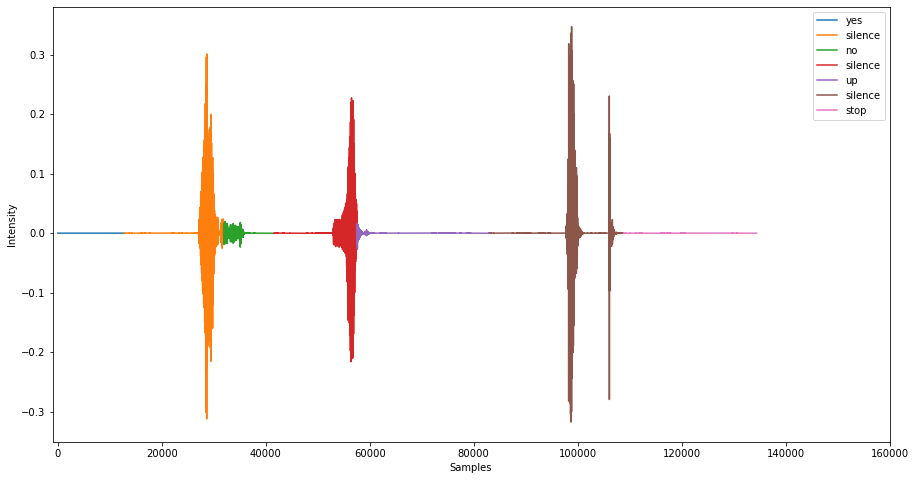

In [41]:
# Plot
plt.figure(figsize=(15, 8))
#plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(-1000, len(myrec))

xaxis=list(range(len(myrec)))
xaxis=np.array(xaxis)

yaxis=[]
xaxis=[]
i=1
temp=list(myrec[:step])
tempx=list(range(0,step))
preds=[]
while i <len(newPredictions):
    
    if newPredictions[i]==newPredictions[i-1]:
        temp+=list(myrec[i*step:(i+1)*step])
        tempx+=list(range(i*step,(i+1)*step))
    else:
        yaxis.append(np.array(temp))
        temp=list(myrec[i*step:(i+1)*step])
        xaxis.append(np.array(tempx))
        tempx=list(range(i*step,(i+1)*step))
        if newPredictions[i]==-1:preds.append("silence")
        else:preds.append(categories[newPredictions[i]])
    i+=1
for i in range(len(yaxis)): print(yaxis[i].shape,xaxis[i].shape)
#for i in range(len(newPredictions)):
    #plt.plot(xaxis[i*step:(i+1)*step],myrec[i*step:(i+1)*step], label=categories[newPredictions[i]])

for i in range(len(yaxis)):
    #plt.plot(xaxis[i*step:(i+1)*step],myrec[i*step:(i+1)*step], label=categories[newPredictions[i]])
    plt.plot(xaxis[i],yaxis[i], label=preds[i])

plt.legend()
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
